In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, sys

nb_path = '/content/drive/MyDrive/Colab Notebooks/site-packages'
sys.path.insert(0, nb_path)  # or append(nb_path)

In [ ]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# First-party imports
from gluonts.dataset.common import ListDataset
import mxnet as mx
from mxnet import gluon
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
mx.random.seed(0)
np.random.seed(0)

## **deepAR**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/태양열 발전량 예측/Timestamped.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Year,Month,Timestamp
0,1,0,0,0,0,1.5,69.08,-12,0.0,2016,1,2016-01-01 00:00:00
1,1,0,30,0,0,1.5,69.06,-12,0.0,2016,1,2016-01-01 00:30:00
2,1,1,0,0,0,1.6,71.78,-12,0.0,2016,1,2016-01-01 01:00:00
3,1,1,30,0,0,1.6,71.75,-12,0.0,2016,1,2016-01-01 01:30:00
4,1,2,0,0,0,1.6,75.20,-12,0.0,2016,1,2016-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
52555,31,21,30,0,0,2.4,70.70,-4,0.0,2018,12,2018-12-31 21:30:00
52556,31,22,0,0,0,2.4,66.79,-4,0.0,2018,12,2018-12-31 22:00:00
52557,31,22,30,0,0,2.2,66.78,-4,0.0,2018,12,2018-12-31 22:30:00
52558,31,23,0,0,0,2.1,67.72,-4,0.0,2018,12,2018-12-31 23:00:00


In [ ]:
df = df.set_index(df['Timestamp'])
cut_edge = pd.to_datetime('2018-12-31 23:30:00') 
temp = df[{'TARGET', 'DHI', 'DNI', 'RH', 'T'}]
# train_end_stamp = pd.to_datetime('2016-06-27 23:30:00')

In [ ]:
prediction_window = 96 # 2 * 48

f1 = temp.DHI.values[:-prediction_window]
f2 = temp.DNI.values[:-prediction_window]
f3 = temp.RH.values[:-prediction_window]
f4 = temp['T'][:-prediction_window].values # callling .T transposes dataframe

In [ ]:
train_ds = ListDataset(
    [{"start": temp.index[0], 
      "target": np.array(temp.TARGET.values[:-prediction_window]),
      "feat_dynamic_real": [f1,f2,f3,f4] }],
    freq = "30min", 
    one_dim_target= True
)

In [ ]:
freq = "30min"

estimator = DeepAREstimator(prediction_length=prediction_window, use_feat_dynamic_real= True , freq=freq, cell_type = 'gru', 
                           trainer=Trainer(epochs=50, batch_size=128, ctx = mx.context.gpu(),))

In [ ]:
predictor = estimator.train(training_data = train_ds)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:18<00:00,  2.64it/s, epoch=50/50, avg_epoch_loss=0.688]


In [ ]:
from pathlib import Path
predictor.serialize(Path("/content/drive/MyDrive/Colab Notebooks/태양열 발전량 예측/"))

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions, backtest_metrics

valid_ds = ListDataset(
    [{"start": temp.index[0], 
      "target": temp.TARGET.values,
      "feat_dynamic_real": [temp.DHI.values, temp.DNI.values, temp.RH.values, temp['T'].values] }],
    freq = "30min",
    one_dim_target= True
)

# test_data의 target 시간 이후부터 예측을 실행하는 것으로 보임. train과 test는 무슨 연관이 있는 것인가 그러면?

forecast_iter, ts_iter = make_evaluation_predictions(valid_ds, predictor=predictor, num_samples=1000)

In [ ]:
forecasts = next(forecast_iter) # forecasts: SampleForecast
tss = next(ts_iter) # tss : pd.DataFrame

In [ ]:
quantile_forecasts = {}
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for quantile in quantiles:
    quantile_forecasts[str(quantile)] = forecasts.quantile(quantile)

In [ ]:
def plot_prob_forecasts(
        ts_entry: Union[pd.DataFrame, pd.Series],
        quantile_forecasts: Union[dict, pd.DataFrame],
        prediction_length=96,
        return_forecasts=True):
    history_length = 48*4

    if isinstance(quantile_forecasts, pd.DataFrame):
        quantile_forecasts.index = ts_entry.index[-quantile_forecasts.prediction_length:]

    elif isinstance(quantile_forecasts, dict):
        quantile_forecasts = pd.DataFrame(quantile_forecasts, index=ts_entry.index[-prediction_length:])

    quantile_forecasts = quantile_forecasts[quantile_forecasts]
    fig, ax = plt.subplots(1, 1, figsize=(18, 10))
    ts_entry[-48 * 4:].plot(ax=ax, linewidth=4, linestyle='dashed')  # plot the history target
    plt.legend('True')
    quantile_forecasts.plot(y=quantile_forecasts.columns, ax=ax, linestyle='solid')

    plt.grid(which="both")
    plt.show()

    if return_forecasts:
        return quantile_forecasts

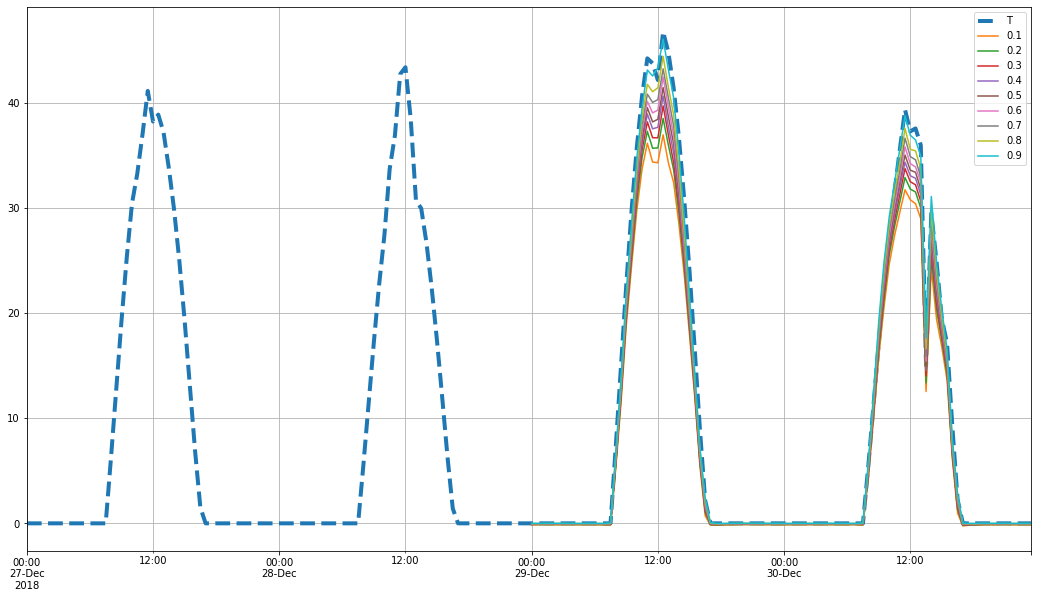

In [ ]:
final_predictions = plot_prob_forecasts(tss, quantile_forecasts)

In [ ]:
final_predictions

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
2018-12-29 00:00:00,-0.140337,-0.114567,-0.099140,-0.084119,-0.071650,-0.057723,-0.040758,-0.022499,0.004002
2018-12-29 00:30:00,-0.135873,-0.111703,-0.093222,-0.080359,-0.065177,-0.051251,-0.037038,-0.020350,0.003351
2018-12-29 01:00:00,-0.127450,-0.106547,-0.090211,-0.079888,-0.066025,-0.052626,-0.038955,-0.024028,-0.002484
2018-12-29 01:30:00,-0.132321,-0.111219,-0.094061,-0.079572,-0.063088,-0.051115,-0.033155,-0.018005,0.004840
2018-12-29 02:00:00,-0.132309,-0.106496,-0.090889,-0.077353,-0.063779,-0.050846,-0.034968,-0.017586,0.005180
...,...,...,...,...,...,...,...,...,...
2018-12-30 21:30:00,-0.133211,-0.111394,-0.094076,-0.079614,-0.065336,-0.051515,-0.036917,-0.020400,0.003678
2018-12-30 22:00:00,-0.135043,-0.107837,-0.092289,-0.077047,-0.063849,-0.052830,-0.036256,-0.021488,-0.000224
2018-12-30 22:30:00,-0.140227,-0.114117,-0.095796,-0.082903,-0.070290,-0.056124,-0.038746,-0.024684,-0.000287
2018-12-30 23:00:00,-0.135609,-0.110204,-0.096166,-0.080824,-0.066578,-0.052592,-0.039787,-0.022573,0.000647


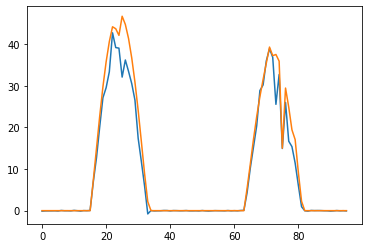

In [ ]:
# 피쳐 4개  T저거 뺄까...
plt.plot(x,predict_entry, answer)

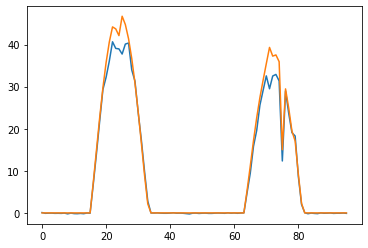

In [ ]:
# 피쳐 3개가 제일 좋아보임
plt.plot(x,predict_entry, answer)

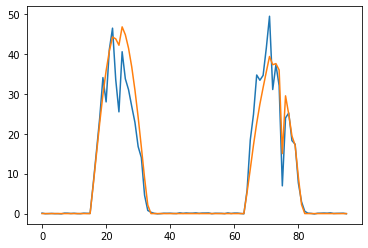

In [ ]:
plt.plot(x,predict_entry, answer)

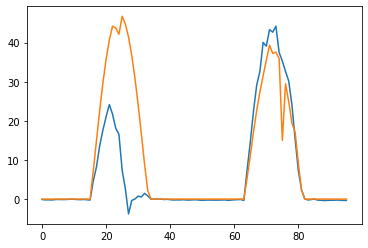

In [ ]:
plt.plot(x,predict_entry, answer)